### Imports

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#### Configurações

In [18]:
# Definir tamanho da sequência para LSTM
sequenceLength = 5
test_ratio = 0.2

# Inicializar modelo
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
epochs = 50

# Definir o símbolo da ação e o período
ticker = "GOOGL"
historical_start_date = "2006-01-01"
historical_end_date = "2024-12-31"

### Obter GPU ou CPU

In [19]:
# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo selecionado: {device} ({torch.cuda.get_device_name(0)})")

Dispositivo selecionado: cuda (NVIDIA GeForce RTX 3060 Ti)


### Download das cotações

In [20]:
# Baixar dados históricos
df = yf.download(ticker, start=historical_start_date, end=historical_end_date)
print(df.tail())
print(len(df), "dias")

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2024-12-23  194.630005  195.100006  190.149994  192.619995  25675000
2024-12-24  196.110001  196.110001  193.779999  194.839996  10403300
2024-12-26  195.600006  196.750000  194.380005  195.149994  12046600
2024-12-27  192.759995  195.320007  190.649994  194.949997  18891400
2024-12-30  191.240005  192.550003  189.119995  189.800003  14264700
4780 dias


### Limpeza e normalização dos dados

In [21]:
# Selecionar apenas a coluna de fechamento
closing_prices = df[['Close']].values

# Normalizar os dados para facilitar o treinamento
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

### Preparando dados para treinamento

In [22]:
# Criar sequência de dados para LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

# Criar conjuntos de treino e teste
data_sequences, data_labels = create_sequences(closing_prices_scaled, sequenceLength)

# Dividir entre treino e teste
test_size = int(len(data_sequences) * test_ratio)
train_X, test_X = data_sequences[:-test_size], data_sequences[-test_size:]
train_y, test_y = data_labels[:-test_size], data_labels[-test_size:]

# Converter para tensores do PyTorch
train_X, train_y = torch.tensor(train_X, dtype=torch.float32).to(device), torch.tensor(train_y, dtype=torch.float32).to(device)
test_X, test_y = torch.tensor(test_X, dtype=torch.float32).to(device), torch.tensor(test_y, dtype=torch.float32).to(device)

# Modelo de dados
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


### Dividindo datasets para treinamento e teste

In [23]:
train_dataset = StockDataset(train_X, train_y)
test_dataset = StockDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train set: {len(train_dataset)} samples, Test set: {len(test_dataset)} samples")

Train set: 3820 samples, Test set: 955 samples


In [24]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinamento do modelo
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")


Epoch 1/50, Loss: 0.005651
Epoch 2/50, Loss: 0.000050
Epoch 3/50, Loss: 0.000036
Epoch 4/50, Loss: 0.000040
Epoch 5/50, Loss: 0.000041
Epoch 6/50, Loss: 0.000037
Epoch 7/50, Loss: 0.000037
Epoch 8/50, Loss: 0.000037
Epoch 9/50, Loss: 0.000039
Epoch 10/50, Loss: 0.000038
Epoch 11/50, Loss: 0.000038
Epoch 12/50, Loss: 0.000038
Epoch 13/50, Loss: 0.000041
Epoch 14/50, Loss: 0.000043
Epoch 15/50, Loss: 0.000033
Epoch 16/50, Loss: 0.000038
Epoch 17/50, Loss: 0.000038
Epoch 18/50, Loss: 0.000038
Epoch 19/50, Loss: 0.000036
Epoch 20/50, Loss: 0.000041
Epoch 21/50, Loss: 0.000035
Epoch 22/50, Loss: 0.000035
Epoch 23/50, Loss: 0.000038
Epoch 24/50, Loss: 0.000042
Epoch 25/50, Loss: 0.000036
Epoch 26/50, Loss: 0.000039
Epoch 27/50, Loss: 0.000037
Epoch 28/50, Loss: 0.000036
Epoch 29/50, Loss: 0.000034
Epoch 30/50, Loss: 0.000037
Epoch 31/50, Loss: 0.000036
Epoch 32/50, Loss: 0.000033
Epoch 33/50, Loss: 0.000031
Epoch 34/50, Loss: 0.000029
Epoch 35/50, Loss: 0.000036
Epoch 36/50, Loss: 0.000036
E

In [25]:
# Avaliação do modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss/len(test_loader):.6f}")
    
# Executar a avaliação
evaluate_model(model, test_loader, criterion)

Test Loss: 0.000468


In [26]:
# Fazer previsão de um conjunto de testes
def predict(model, data_loader):
    model.eval()
    predictions = []
    actual_values = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actual_values.extend(targets.cpu().numpy())
    
    return np.array(predictions), np.array(actual_values)

# Obter previsões
predictions, actual_values = predict(model, test_loader)

# Desserializar valores para escala original
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(actual_values)

In [27]:
# Calcular Erros
mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))

print(f"Hidden Size {hidden_size} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Hidden Size 50 - MAE: 3.2002, RMSE: 4.0767


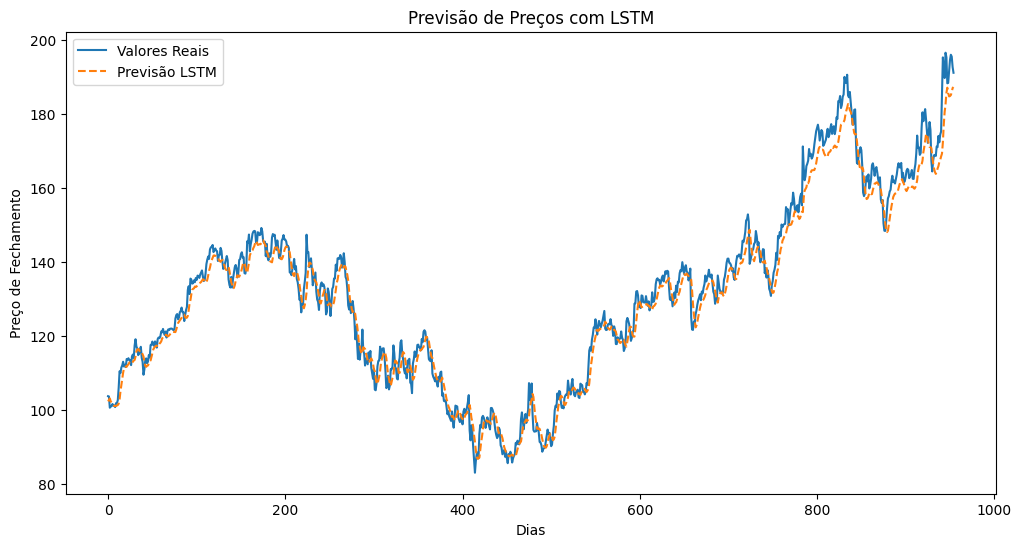

In [28]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Valores Reais")
plt.plot(predictions, label="Previsão LSTM", linestyle="dashed")
plt.xlabel("Dias")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.title("Previsão de Preços com LSTM")
plt.show()

In [29]:
# Função que recebe uma data futura (no formato 2025-01-28), que não fez parte do treinamento, e realiza a predição no modelo já treinado
def predict_future(model, date):
    # Obter os últimos 5 dias de fechamento
    last_5_days = df.loc[:date].tail(sequenceLength)
    last_5_days_scaled = scaler.transform(last_5_days[['Close']].values)
    last_5_days_scaled = torch.tensor(last_5_days_scaled, dtype=torch.float32).to(device)
    last_5_days_scaled = last_5_days_scaled.reshape(1, sequenceLength, 1)
    
    # Fazer a predição
    with torch.no_grad():
        model.eval()
        prediction = model(last_5_days_scaled)
    
    # Desserializar valor para escala original
    prediction = scaler.inverse_transform(prediction.cpu().numpy())
    
    return prediction[0][0]

print(df.loc[:"2025-01-10"].tail(sequenceLength))

Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2024-12-23  194.630005  195.100006  190.149994  192.619995  25675000
2024-12-24  196.110001  196.110001  193.779999  194.839996  10403300
2024-12-26  195.600006  196.750000  194.380005  195.149994  12046600
2024-12-27  192.759995  195.320007  190.649994  194.949997  18891400
2024-12-30  191.240005  192.550003  189.119995  189.800003  14264700


In [30]:
def predict_future(model, last_sequence, future_days):
    model.eval()
    predictions = []

    last_sequence = df.tail(100)
    current_sequence = torch.tensor(last_sequence, dtype=torch.float32).to(device)

    with torch.no_grad():
        for _ in range(future_days):
            # Fazer previsão para o próximo dia
            next_value = model(current_sequence)
            
            # Adicionar previsão à lista
            predictions.append(next_value.cpu().numpy()[0, 0])
            
            # Atualizar sequência para incluir a nova previsão
            next_value_tensor = next_value.unsqueeze(0)  # Adicionar dimensão extra
            current_sequence = torch.cat((current_sequence[:, 1:, :], next_value_tensor.unsqueeze(2)), dim=1)

    # Desserializar previsões para a escala original
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions

# 🔹 Corrigir `last_known_data`
last_known_data = predictions[-100:]  # Converter para array NumPy

# Número de dias a prever
future_days = 30

# Fazer previsão para 2025
future_predictions = predict_future(model, last_known_data, future_days)

# Exibir previsões
print(f"Previsões para os próximos {future_days} dias em 2025:\n", future_predictions)


ValueError: could not determine the shape of object type 'DataFrame'